In [25]:
import pandas as pd
import jieba
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.src.layers import Embedding, Conv1D, MaxPooling1D, concatenate, Flatten, Dropout, Dense
from keras import Input, Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [3]:
#读取数据集
X_train = pd.read_csv('data/X_train_minmaxscaler.csv')['ChatGPT回答'].iloc[:100]
X_test = pd.read_csv('data/X_test_minmaxscaler.csv')['ChatGPT回答'].iloc[:100]
y_train = pd.read_csv('data/y_train_minmaxscaler.csv').iloc[:100,:]
y_test = pd.read_csv('data/y_test_minmaxscaler.csv').iloc[:100,:]

In [10]:
#处理数据

cw = lambda x: list(jieba.cut(x))
X_train_text = X_train.apply(cw)
X_test_text = X_test.apply(cw)

tokenizer=Tokenizer()  #创建一个Tokenizer对象
#fit_on_texts函数可以将输入的文本中的每个词编号，编号是根据词频的，词频越大，编号越小
tokenizer.fit_on_texts(X_train_text)
tokenizer.fit_on_texts(X_test_text)
vocab=tokenizer.word_index #得到每个词的编号

# 将每个样本中的每个词转换为数字列表，使用每个词的编号进行编号
X_train_word_ids=tokenizer.texts_to_sequences(X_train_text)
X_test_word_ids = tokenizer.texts_to_sequences(X_test_text)
#序列模式
# 每条样本长度不唯一，将每条样本的长度设置一个固定值
X_train_padded_seqs=pad_sequences(X_train_word_ids,maxlen=256) #将超过固定值的部分截掉，不足的在最前面用0填充
X_test_padded_seqs=pad_sequences(X_test_word_ids, maxlen=256)

In [ ]:
#Smote不均衡采样
from imblearn.over_sampling import SMOTE
def smote(X_t, y_t):
    # Create an instance of SMOTE
    s = SMOTE(random_state=10)
    # Apply SMOTE to the training data
    X_train_resampled, y_train_resampled = s.fit_resample(X_t, y_t)
    return X_train_resampled, y_train_resampled

In [ ]:
#smote采样
# X_train_padded_seqs, y_train = smote(X_train_padded_seqs, y_train)
# X_test_padded_seqs, y_test = smote(X_test_padded_seqs, y_test)

In [12]:
#构建TextCNN模型
#模型结构：词嵌入-卷积池化*3-拼接-全连接-dropout-全连接
main_input = Input(shape=(256,), dtype='float64')
# 词嵌入（使用预训练的词向量）
embedder = Embedding(len(vocab) + 1, 300, input_length=256, trainable=False)
embed = embedder(main_input)
# 词窗大小分别为3,4,5
cnn1 = Conv1D(256, 3, padding='same', strides=1, activation='relu')(embed)
cnn1 = MaxPooling1D(pool_size=48)(cnn1)
cnn2 = Conv1D(256, 4, padding='same', strides=1, activation='relu')(embed)
cnn2 = MaxPooling1D(pool_size=47)(cnn2)
cnn3 = Conv1D(256, 5, padding='same', strides=1, activation='relu')(embed)
cnn3 = MaxPooling1D(pool_size=46)(cnn3)
# 合并三个模型的输出向量
cnn = concatenate([cnn1, cnn2, cnn3], axis=-1)
flat = Flatten()(cnn)
drop = Dropout(0.2)(flat)
main_output = Dense(1, activation='sigmoid')(drop)
model = Model(inputs=main_input, outputs=main_output)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 256, 300)             828600    ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 256, 256)             230656    ['embedding[0][0]']           
                                                                                                  
 conv1d_1 (Conv1D)           (None, 256, 256)             307456    ['embedding[0][0]']           
                                                                                              

In [15]:
def on_epoch_end(epoch, logs):
    # print(f'Epoch {epoch + 1}, Loss: {logs["loss"]}') 
    print(f'Epoch {epoch + 1}')
    train_loss = logs.get('loss')
    val_loss = logs.get('val_loss')
    train_acc = logs.get('accuracy')
    val_acc = logs.get('val_accuracy')

    print(f'Epoch {epoch + 1}, Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
          f'Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    print("\n")

In [21]:
from keras.src.callbacks import LambdaCallback
#训练模型
# one_hot_labels = keras.utils.to_categorical(y_train, num_classes=3)  # 将标签转换为one-hot编码
callback = LambdaCallback(on_epoch_end=on_epoch_end)
history=model.fit(X_train_padded_seqs, y_train, batch_size=32, epochs=32,validation_split=0.2,callbacks=[callback])

Epoch 1/10
3/3 [==============================] - ETA: 0s - loss: 0.0303 - accuracy: 0.9750Epoch 1
Epoch 1, Loss: 0.0303, Val Loss: 0.0987, Acc: 0.9750, Val Acc: 0.9000


3/3 [==============================] - 3s 819ms/step - loss: 0.0303 - accuracy: 0.9750 - val_loss: 0.0987 - val_accuracy: 0.9000
Epoch 2/10
3/3 [==============================] - ETA: 0s - loss: 0.0254 - accuracy: 0.9750Epoch 2
Epoch 2, Loss: 0.0254, Val Loss: 0.0997, Acc: 0.9750, Val Acc: 0.9000


3/3 [==============================] - 1s 495ms/step - loss: 0.0254 - accuracy: 0.9750 - val_loss: 0.0997 - val_accuracy: 0.9000
Epoch 3/10
3/3 [==============================] - ETA: 0s - loss: 0.0224 - accuracy: 0.9750Epoch 3
Epoch 3, Loss: 0.0224, Val Loss: 0.1031, Acc: 0.9750, Val Acc: 0.9000


3/3 [==============================] - 2s 504ms/step - loss: 0.0224 - accuracy: 0.9750 - val_loss: 0.1031 - val_accuracy: 0.9000
Epoch 4/10
3/3 [==============================] - ETA: 0s - loss: 0.0190 - accuracy: 0.9750Epoch 4
E

In [17]:
# 保存整个模型到一个HDF5文件  
# model.save('textCNN_model.h5')  

In [22]:
# 评估模型
score = model.evaluate(X_test_padded_seqs, y_test, verbose=0)  
print('Test loss:', score[0])  
print('Test accuracy:', score[1])

Test loss: 0.17024396359920502
Test accuracy: 0.7900000214576721


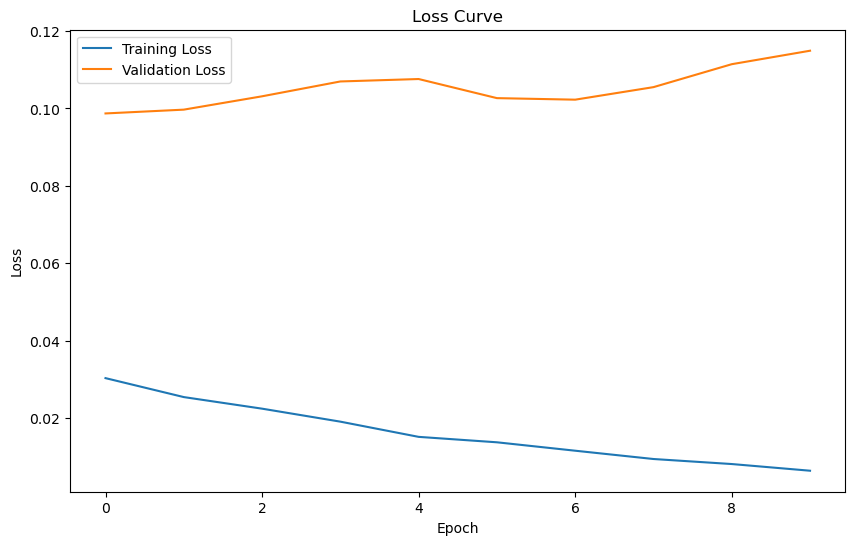

In [23]:
 # history.history 字典将包含每个epoch的loss和val_loss值  
loss = history.history['loss']  
val_loss = history.history['val_loss']
 
# 绘制训练和验证loss曲线  
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')  
plt.plot(val_loss, label='Validation Loss')  
plt.title('Loss Curve')  
plt.xlabel('Epoch')  
plt.ylabel('Loss')  
plt.legend()  
#保存loss曲线
# plt.savefig('txtCNN_loss_curve.png')
plt.show()

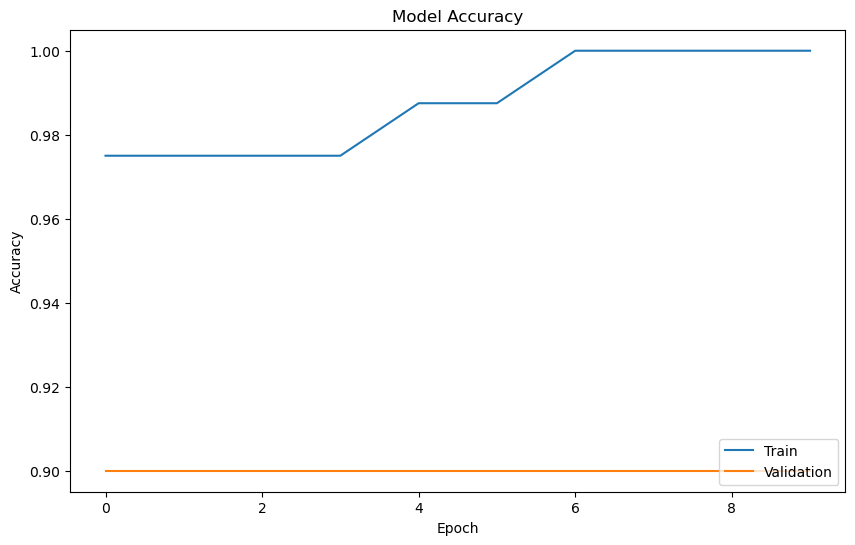

In [24]:
#绘制准确率曲线
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
# plt.savefig('txtCNN_accuracy.png')
plt.show()

In [26]:
#TextCNN模型的评价
def evaluate_textCNN_model(model, X_test, y_test):

    # Predict probabilities
    y_pred_proba = model.predict(X_test)
    
    # Predict labels
    y_pred=np.where(y_pred_proba>0.5,1,0)
    
    
    # Calculate accuracy, precision, recall, F1-score, and AUC
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    
    return [accuracy, precision, recall, f1, auc,fpr.tolist(), tpr.tolist()]

In [27]:
import json
import tensorflow as tf
#计算每个模型的评价指标,
metrics_name = ['accuracy', 'precision', 'recall', 'f1-score','auc','fpr-score','tpr-score']
#计算每个模型的评价指标值，然后按照模型名，指标名称将结果存入一个字典

metrics = evaluate_textCNN_model(model, tf.convert_to_tensor(X_test_padded_seqs), y_test)
textCNN_metrics_dict = {metrics_name[j]: metrics[j] for j in range(len(metrics))}

4/4 [==============================] - 0s 78ms/step


C:\Users\mi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#以json文件保存字典结果
with open('textCNN_metrics_dict.json', 'w') as f:
    json.dump(textCNN_metrics_dict, f)